### Download the movie dataset

In [ ]:
!wget -o moviedataset.zip http://files.grouplens.org/datasets/movielens//ml-1m.zip
!unzip -o moviedataset.zip -d moviedataset

### Import the Libraries

In [3]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf 

#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np

#Dataframe manipulation library
import pandas as pd

#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Data

In [4]:
movies_df = pd.read_csv("./moviedataset/movies.dat", sep='::', header=None)
movies_df.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df = pd.read_csv("./moviedataset/ratings.dat", sep='::', header=None)
ratings_df.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [7]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### The RBM Model - Restricted Boltzmann Machine Model

In [9]:
#Formatting data
len(movies_df)

3883

In [10]:
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [11]:
movies_df['List_Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List_Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [12]:
# Merge Ratings Dataframe with Movies dataframe
merged_df = movies_df.merge(ratings_df, on='MovieID')

# Dropping unnecessary Columns
merged_df = merged_df.drop(['Timestamp', 'Title', 'Genres'], axis=1)

# Display the Result
merged_df.head()

,MovieID,List_Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [13]:
# Group up by userID
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List_Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [14]:
# Format the data for input to RBM Model

amount_of_used_users = 1000
trx = []

# For each user in userGroup
for userID, curUser in userGroup:
    temp = [0]*len(movies_df)
    
    # For each movie in curUser's movie List
    for rum, movie in curUser.iterrows():
        temp[movie['List_Index']] = movie['Rating']/5.0
    
    # Now add the list of ratings into the training list
    trx.append(temp)
    
    # Check if we finished adding in amount of users for training
    if amount_of_used_users == 0:
        break
    amount_of_used_users -= 1

### Setting the Model parameter

In [15]:
hiddenUnits = 20
visibleUnits = len(movies_df)

# No of Unique Movies
vb = tf.placeholder('float', [visibleUnits])

# No of Features we're going to train
hb = tf.placeholder('float', [hiddenUnits])

W = tf.placeholder('float', [visibleUnits, hiddenUnits])

In [16]:
# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [17]:
# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [18]:
# Playing around Learning Rate

alpha = 1.0

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [19]:
# Error Fucntion - Mean Absolute Error Function
err = v0 -v1
err_sum = tf.reduce_mean(err * err)

### Initialize the Variables using Numpy

In [20]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Train the RBM

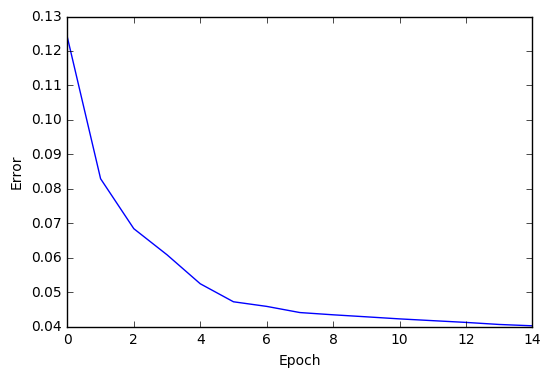

In [21]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trx), batchsize), range(batchsize, len(trx), batchsize)):
        batch = trx[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trx, W: cur_w, vb: cur_vb, hb: cur_nb}))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [23]:
# Selecting the input user
inputUser = [trx[75]]

In [24]:
# Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [25]:
movies_df["Recommendation Score"] = rec[0]
movies_df.sort(["Recommendation Score"], ascending=False).head(20)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,MovieID,Title,Genres,List_Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.701714
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.654768
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.606318
523,527,Schindler's List (1993),Drama|War,523,0.548268
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.534174
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.521075
293,296,Pulp Fiction (1994),Crime|Drama,293,0.520139
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.518849
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.511394
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.480032
